# Лабораторная работа по Relevance Vector Regression
В рамках этой лабораторной работы необходимо:
- Имплементировать Relevance Vector Regression
- Применить на синетическом датасете (восстановление полинома), сравнить с Lasso из sklearn и гребневой регрессией
- Применить на данных sinc с RBF признаками, визуализировать "релевантные вектора", сравнить с Support Vector Regression и Lasso
- Сделать выводы

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function

%matplotlib inline
np.random.seed(123)

def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Имплементация Relevance Vector Regression

Здесь необходимо реализовать четыре функции:

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели
4. `get_posterior_predictive(X, w, sigma, alpha, beta)`, которая принимает матрицу признаков X, параметры апостериорного распределения на веса (w, sigma), гиперпараметры RVR (alpha, beta) и вычисляет среднее и стандартное отклонение распределения $p(t | x, (X_{train}, t_{train}), \alpha, \beta)$ для предсказаний на новых точках из матрицы X

На что стоит обратить внимание:

1. Результаты дорогостоящих операций типа перемножения одних и тех же матриц нужно кешировать и переиспользовать
2. $\alpha$-ы для нерелевантных объектов должны принять значение `np.inf`, а соответствующие веса и их дисперсии должны иметь значение 0
3. Бесконечности и нули из предыдущего пункта должны обрабатываться корректно, без NaN-ов и warning-ов
4. Матрицу с бесконечными элементами на диагонали можно обращать более эффективно (достаточно обратить подматрицу)

In [65]:
def get_w_sigma(X, t, alpha, beta):
    """Calculate the mean and the covariance matrix
       of the posterior distribution"""
    n, d = X.shape
    
    sigma = np.linalg.inv(beta * (X.T @ X) + np.diag(alpha))
    w = beta * sigma @ X.T @ t
    
    return w, sigma


def update_alpha_beta(X, t, alpha, beta):
    """Update the hyperperemeters to increase evidence"""
    n, d = X.shape

    sigma = np.linalg.inv(beta * (X.T @ X) + np.diag(alpha))
    w = beta * sigma @ X.T @ t
    
    alpha_new_list = []
    for j in range(d):
        alpha_new_list.append((1 - alpha[j] * sigma[j, j]) / (w[j] ** 2))
    alpha_new = np.array(alpha_new_list)
    den_beta = t - (X @ w).ravel()
    beta_new = (d - sum(((1 - alpha[j] * sigma[j, j]) for j in range(d)))) / (den_beta @ den_beta)
    
    return alpha_new, beta_new


def fit_rvr(X, t, max_iter=20):
    """Train the Relevance Vector Regression model"""
    n, d = X.shape
    alpha = np.ones(d)
    beta = 1
    
    for i in range(max_iter):
        alpha, beta = update_alpha_beta(X, t, alpha, beta)
        
    w, sigma = get_w_sigma(X, t, alpha, beta)
    
    return w, sigma, alpha, beta

def get_posterior_predictive(X, w, sigma, alpha, beta):
    """" Compute the mean and the standard deviation
         of the posterior predictive distribution for inputs X"""

    mu = (X @ w[:, np.newaxis]).ravel()
    std = np.sqrt(1 / beta + np.diag(X @ sigma @ X.T))
    
    return mu, std

## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

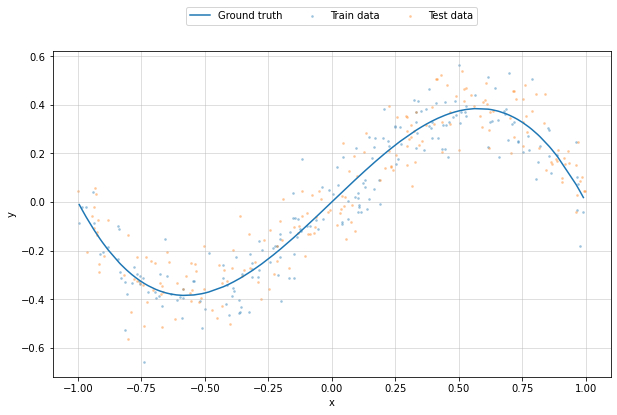

In [25]:
# Data generation

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-1, 1, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 1
w_true[3] = -1
beta_true = 100

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

ax.grid(True, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [26]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

In [27]:
predictive_mu, predictive_std = get_posterior_predictive(
    X_test,
    w_rvr,
    sigma_rvr,
    alpha_rvr,
    beta_rvr)

In [28]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=20, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_

In [29]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
lasso = LassoCV(cv=5, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False, max_iter=2000000).fit(X_train, t_train)
w_lasso = lasso.coef_

c:\users\илья\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006909801133109905, tolerance: 0.0012854460800422094
  model = cd_fast.enet_coordinate_descent_gram(


Relevance Vector Regression
Features remaining: 13 / 21
Train error: 0.008914591129765536
Test error:  0.010042499533956977
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 0.009095034553223597
Test error:  0.009961442053083646
--------------------------------------------------
Lasso Regression
Features remaining: 9 / 21
Train error: 0.008878963547469502
Test error:  0.010139505424318318


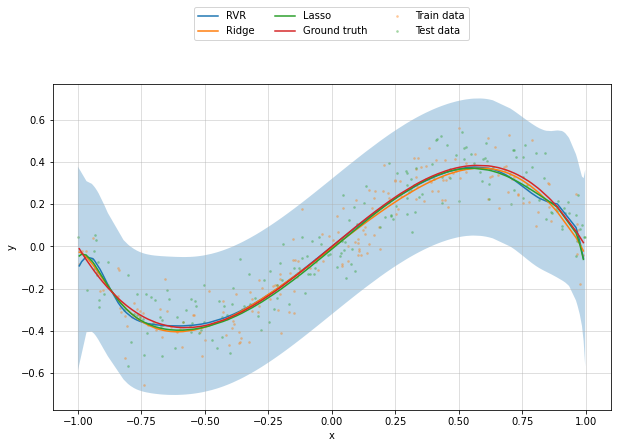

In [30]:
# Comparison
print('Relevance Vector Regression')
print('Features remaining:', np.sum(alpha_rvr < 1e8), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-20), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(X_test[:, 1],
                predictive_mu - predictive_std,
                predictive_mu + predictive_std,
                alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
ax.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
ax.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)


ax.grid(True, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Регрессия с RBF-признаками

Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром (можно использовать функцию `sklearn.metrics.pairwise.rbf_kernel`), обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

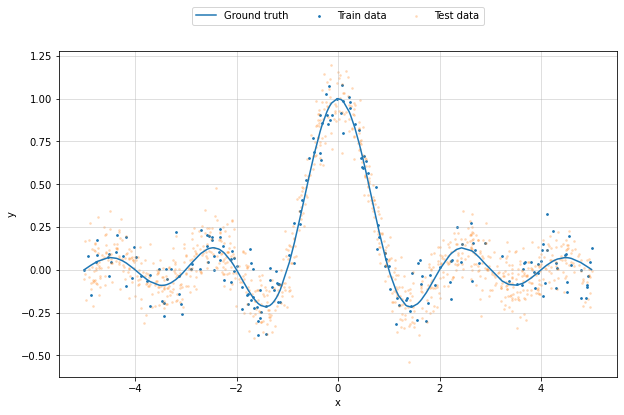

In [66]:
# Data generation
from sklearn.metrics.pairwise import rbf_kernel

def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 200
n_test = 1000
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n_test, beta_true)

# RBF-transform
# X_train = rbf_kernel(np.hstack([points_train[:, np.newaxis] ** i for i in range(1, d + 1)]))
# X_test = rbf_kernel(np.hstack([points_test[:, np.newaxis] ** i for i in range(1, d + 1)]), np.hstack([points_train[:, np.newaxis] ** i for i in range(1, d + 1)]))
X_train = rbf_kernel(np.hstack([points_train[:, np.newaxis] ** i for i in range(21)]))
X_test = rbf_kernel(np.hstack([points_test[:, np.newaxis] ** i for i in range(21)]), np.hstack([points_train[:, np.newaxis] ** i for i in range(21)]))

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n_test, 1)), X_test))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=1)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.2)
ax.plot(points_train, np.sinc(points_train), label='Ground truth')

ax.grid(True, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [67]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

In [68]:
predictive_mu, predictive_std = get_posterior_predictive(
    X_test,
    w_rvr,
    sigma_rvr,
    alpha_rvr,
    beta_rvr)

In [69]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=10, alphas=10.**np.linspace(-5, 1, 20),
                fit_intercept=False, max_iter=100000, tol=1e-2, n_jobs=10).fit(X_train, t_train)
w_lasso = lasso.coef_

In [70]:
# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

Relevance Vector Regression
Objects remaining: 152 / 200
Train error: 0.0025695598464478765
Test error:  0.09099831949480441
--------------------------------------------------
Lasso Regression
Objects remaining: 16 / 200
Train error: 0.03293975074546748
Test error:  0.16542377019820875
--------------------------------------------------
Support Vector Regression
Objects remaining: 74 / 200
Train error: 0.01062044020532938
Test error:  0.05982762835374359


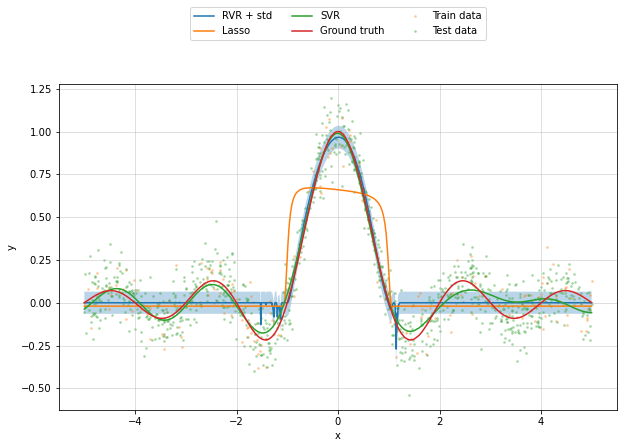

In [71]:
# Comparison
print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-'*50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(points_test,
                predictive_mu - predictive_std,
                predictive_mu + predictive_std, alpha=0.3)
ax.plot(points_test, X_test.dot(w_rvr), label='RVR + std')
ax.plot(points_test, X_test.dot(w_lasso), label='Lasso')
ax.plot(points_test, svr.predict(points_test.reshape(-1, 1)), label='SVR')
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)


ax.grid(True, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

### Визуализация релевантных объектов для RVR

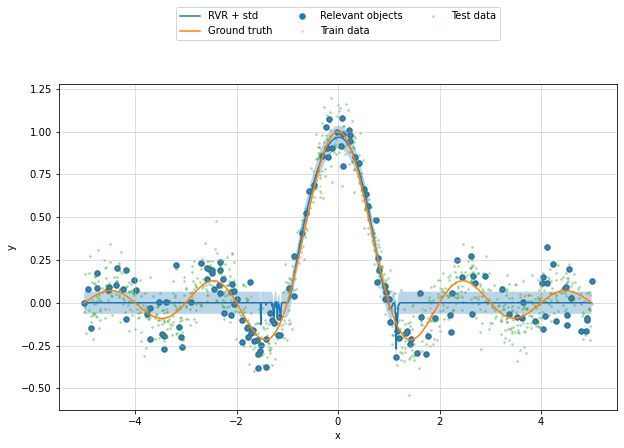

In [72]:
relevant = alpha_rvr[1:] < 1e8
fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(points_test,
                predictive_mu - predictive_std,
                predictive_mu + predictive_std, alpha=0.3)
ax.plot(points_test, X_test.dot(w_rvr), label='RVR + std')
ax.scatter(points_train[relevant], t_train[relevant], c='tab:blue', s=30, label='Relevant objects')
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)

ax.grid(True, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Выводы
В этом поле опишите свои наблюдения и сформулируйте свои выводы

Relevance Vector Regression позволяет отбирать релевантные признаки. Так же главным достоинством данного метода является то, что в результате получается не точечное прогнозное решение, а целое прогнозное распределение на целевую переменную. Таким образом мы можем оценить не только точность предсказания, но и уверенность модели в данном предсказании, например это можно сделать исходя из дисперсии прогнозного распределения.

В задаче восстановления полинома RVR справилась отлично, разницы в точности прогноза между RVR, Ridge и Lasso почти нет.
В задаче регрессии с RBF-признаками RVR показала качество на тесте лучше чем у Lasso, но хуже, чем у SVR.
В первой задаче RVR оставила 13 признаков из 21, а во второй задаче -- 152 из 200.